# Phase Test

## Freq Sweep Program

In [65]:
import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.averager_program import QickSweep, merge_sweeps
from qick.asm_v1 import QickRegister
from qick.pyro import make_proxy

RegisterType = ["freq", "time", "phase", "adc_freq"]

MHz = 1
class FreqSweepExample(RAveragerProgram):
    def initialize(self):
        self.phrst = 0
        # Set the nyquist zone
        cfg = self.cfg
        freq_rf     = cfg["start"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = int(cfg["pulse_time"] * 3/4) - 10,    # Readout length
                                                            # 10 is subtracted to
                                                            # make margin in timing
        )
        (self.ro_rp, self.ro_freq) = self._ro_regmap[0, "freq"]
        (self.gen_rp, self.gen_freq) = self._gen_regmap[0, "freq"]
        # Convert RF frequency to DAC DDS register value
        self.freq_dac = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        self.freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )
        # Make endless pulse
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac, # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = cfg["gain"],  # Generator amplitude
            phrst   = self.phrst,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = self.freq_adc, # Readout DDS frequency
            length  = 1600,       # Dummy length
            phrst   = self.phrst,        # Readout DDS phase reset
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.synci(100000)

    def body(self):
        cfg = self.cfg
        # Put the generator's frequency register to temporary register (page : 0, register : 6)
        self.mathi(self.gen_rp, 6, self.gen_freq, '+', 0)
        self.mathi(self.ro_rp, 6, self.ro_freq, '+', 0)
        # Make endless pulse
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac,    # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = cfg["gain"],  # Generator amplitude
            phrst   = self.phrst,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        # Set demodulator DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = self.freq_adc, # Readout DDS frequency
            length  = 1600,       # Dummy length
            phrst   = self.phrst,        # Readout DDS phase reset
        )
        self.mathi(self.gen_rp, self.gen_freq, 6, '+', 0)
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 100
        )
        
        self.mathi(self.ro_rp, self.ro_freq, 6, '+', 0)
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        # Make measurement triggers and shift t_sync
        for i in range(cfg["number_of_pulse"]):
            self.sync_all()
            self.trigger(
                adcs    = [0],      # Readout channels
                adc_trig_offset = 150 # Readout will capture the data @ sync_t + 50
            )

        self.sync_all(100)
        
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac,    # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = 0,  # Generator amplitude
            phrst   = self.phrst,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.mathi(self.gen_rp, self.gen_freq, 6, '+', 0)
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 100
        )
        self.sync_all(1000)
        # Make sure that do not read buffer before experiment ends
        self.wait_all()
    
    def update(self): 
        # Update readout frequency register 
        self.mathi(
            self.ro_rp, self.ro_freq, self.ro_freq, '+',
            self.freq2reg_adc(self.cfg["step"], 0, 0)
        )
        # Update generator frequency register
        self.mathi(
            self.gen_rp, self.gen_freq, self.gen_freq, '+',
            self.freq2reg(self.cfg["step"], 0, 0)
        )
        self.synci(10)

## Get SoC Instance

In [66]:
# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_9d369bee84084fc19b57abe94672fcca@192.168.2.99:42971


## Set Up Filter and Attenuator

In [67]:
dac_att1 = 31
dac_att2 = 31
# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,dac_att1,dac_att2)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

adc_att = 31
# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,adc_att)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

## Set Up Program

In [68]:
dac_gain = 1084

cfg = {
    # Experiment Setup
    "reps" : 1,
    "expts" : 800,
    "start" : 500,
    "step" : 0.1,
    "gain" : dac_gain,
    # Parameter Setup
    "pulse_time" : 65000,
    "number_of_pulse" : 500,
}
prog = FreqSweepExample(
    soccfg,
    cfg
)
print(prog)


// Program

        regwi 0, $22, 447392427;                //freq = 447392427
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1084;                     //gain = 1084
        regwi 0, $26, 852068;                   //phrst| stdysel | mode | | outsel = 0b01101 | length = 100 
        regwi 4, $22, 894784854;                //freq = 894784854
        regwi 4, $26, 263744;                   //mode | outsel = 0b00100 | length = 1600 
        synci 100000;
        regwi 0, $13, 0;
        regwi 0, $14, 799;
LOOP_I: regwi 0, $15, 0;
LOOP_J: mathi 0, $6, $22 + 0;
        mathi 4, $6, $22 + 0;
        regwi 0, $22, 447392427;                //freq = 447392427
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1084;                     //gain = 1084
        regwi 0, $26, 852068;                   //phrst| stdysel | mode | | outsel = 0b01101 | length = 100 
        regwi 4, $22, 894784854;                //freq = 894784854
       

## Run Program

In [69]:
expts, avgi, avgq  = prog.acquire(soc = soc, progress = True, start_src = "internal")
avgi = np.array(avgi[0]).mean(axis = 0)
avgq = np.array(avgq[0]).mean(axis = 0)

meas_power = 10 * np.log10(avgi * avgi + avgq * avgq)
meas_phase = np.angle(avgi + 1j * avgq)

  0%|          | 0/800 [00:00<?, ?it/s]

## Plot Results

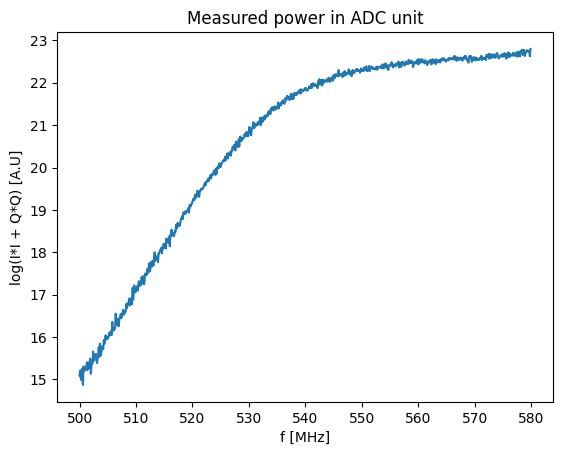

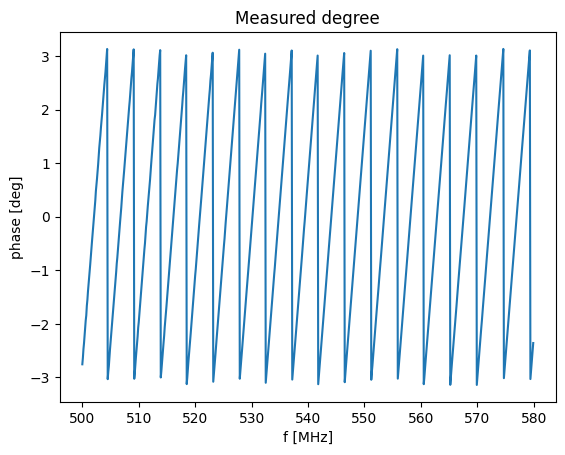

In [71]:
plt.figure()
plt.plot(expts, meas_power)
plt.xlabel("f [MHz]")
plt.ylabel("log(I*I + Q*Q) [A.U]")
plt.title("Measured power in ADC unit")
plt.show()

plt.plot(expts, meas_phase)
plt.xlabel("f [MHz]")
plt.ylabel("phase [deg]")
plt.title("Measured degree")
plt.show()

## Run with small frequency

In [72]:
dac_gain = 1084

cfg = {
    # Experiment Setup
    "reps" : 1,
    "expts" : 80,
    "start" : 500,
    "step" : 0.1,
    "gain" : dac_gain,
    # Parameter Setup
    "pulse_time" : 65000,
    "number_of_pulse" : 500,
}
prog = FreqSweepExample(
    soccfg,
    cfg
)
print(prog)

expts, avgi, avgq  = prog.acquire(soc = soc, progress = True, start_src = "internal")
avgi = np.array(avgi[0]).mean(axis = 0)
avgq = np.array(avgq[0]).mean(axis = 0)

meas_power = 10 * np.log10(avgi * avgi + avgq * avgq)
meas_phase = np.angle(avgi + 1j * avgq)


// Program

        regwi 0, $22, 447392427;                //freq = 447392427
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1084;                     //gain = 1084
        regwi 0, $26, 852068;                   //phrst| stdysel | mode | | outsel = 0b01101 | length = 100 
        regwi 4, $22, 894784854;                //freq = 894784854
        regwi 4, $26, 263744;                   //mode | outsel = 0b00100 | length = 1600 
        synci 100000;
        regwi 0, $13, 0;
        regwi 0, $14, 79;
LOOP_I: regwi 0, $15, 0;
LOOP_J: mathi 0, $6, $22 + 0;
        mathi 4, $6, $22 + 0;
        regwi 0, $22, 447392427;                //freq = 447392427
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1084;                     //gain = 1084
        regwi 0, $26, 852068;                   //phrst| stdysel | mode | | outsel = 0b01101 | length = 100 
        regwi 4, $22, 894784854;                //freq = 894784854
        

  0%|          | 0/80 [00:00<?, ?it/s]

## Plot Result

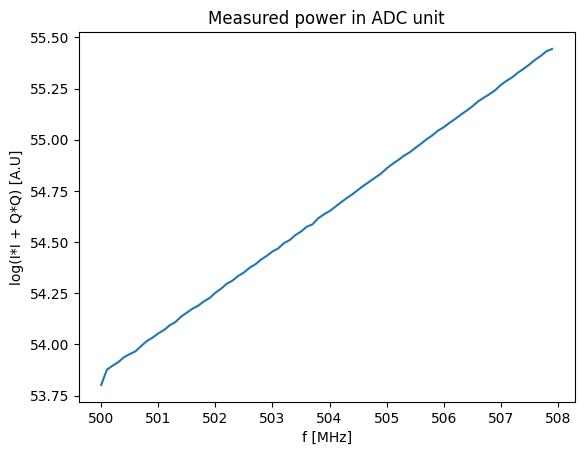

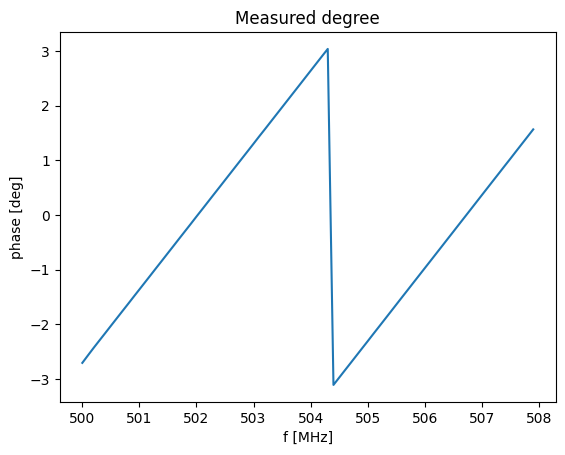

In [73]:
plt.figure()
plt.plot(expts, meas_power)
plt.xlabel("f [MHz]")
plt.ylabel("log(I*I + Q*Q) [A.U]")
plt.title("Measured power in ADC unit")
plt.show()

plt.plot(expts, meas_phase)
plt.xlabel("f [MHz]")
plt.ylabel("phase [deg]")
plt.title("Measured degree")
plt.show()